In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# SpikeInterface pipeline for Mease Lab - Syntalos

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from datetime import datetime, timedelta
from isodate import duration_isoformat

import spikeextractors as se
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc
import spikewidgets as sw
from nwb_conversion_tools.json_schema_utils import dict_deep_update
from nwb_conversion_tools.conversion_tools import save_si_object

from mease_lab_to_nwb import SyntalosNWBConverter, SyntalosRecordingExtractor, SyntalosRecordingInterface
from mease_lab_to_nwb.convert_syntalos.syntalosnwbconverter import quick_write

## 1) Load Intan recordings, compute LFP, and inspect signals

In [3]:
syntalos_folder = Path('D:/Syntalos/Latest Syntalos Recording _20200730/intan-signals')
#syntalos_folder = Path('/Users/abuccino/Documents/Data/catalyst/heidelberg/syntalos/Latest_Syntalos_Recording_20200730/')
spikeinterface_folder = syntalos_folder / "spikeinterface"

In [4]:
recording = SyntalosRecordingExtractor(syntalos_folder)

d:\github\pyintan\pyintan\tools.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  states = np.array(states)


### Stub recording for fast testing; set to False for running processing pipeline on entire data

In [5]:
stub_test = True
nsec_stub = 10

### Compute LFP

In [6]:
freq_min_lfp = 1
freq_max_lfp = 300
freq_resample_lfp = 1000.

In [7]:
recording_lfp = st.preprocessing.bandpass_filter(recording, freq_min=freq_min_lfp, freq_max=freq_max_lfp)
recording_lfp = st.preprocessing.resample(recording_lfp, freq_resample_lfp)

In [8]:
print(f"Sampling frequency AP: {recording.get_sampling_frequency()}")
print(f"Sampling frequency LF: {recording_lfp.get_sampling_frequency()}")      

Sampling frequency AP: 30000.0
Sampling frequency LF: 1000.0


### Inspect signals

<IPython.core.display.Javascript object>


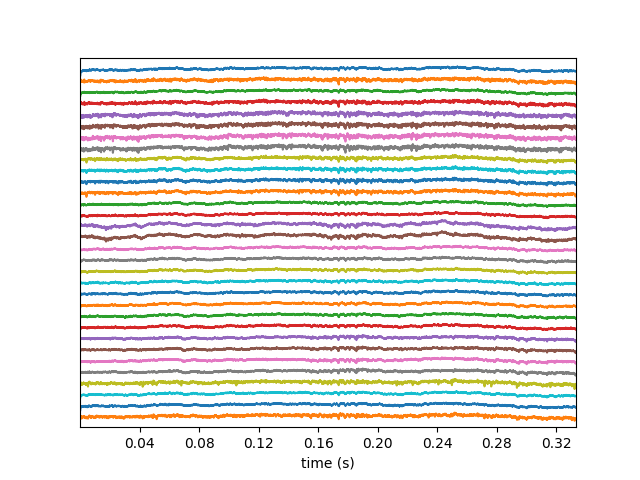

In [9]:
w_ts_ap = sw.plot_timeseries(recording)

In [ ]:
w_ts_lf = sw.plot_timeseries(recording_lfp, trange=[10, 15])

<IPython.core.display.Javascript object>

## 2) Pre-processing

In [ ]:
apply_filter = True
apply_cmr = True
freq_min_hp = 300
freq_max_hp = 3000

In [ ]:
if apply_filter:
    recording_processed = st.preprocessing.bandpass_filter(recording, freq_min=freq_min_hp, freq_max=freq_max_hp)
else:
    recording_processed = recording

if apply_cmr:
    recording_processed = st.preprocessing.common_reference(recording_processed)

In [ ]:
print(recording.get_dtype())
print(recording_processed.get_dtype())

In [ ]:
if stub_test:
    recording_processed = se.SubRecordingExtractor(recording_processed, end_frame=int(nsec_stub*recording_processed.get_sampling_frequency()))
    recording_lfp = se.SubRecordingExtractor(recording_lfp, end_frame=int(nsec_stub*recording_lfp.get_sampling_frequency()))

In [ ]:
recording_processed.get_num_frames()

In [ ]:
w_ts_ap = sw.plot_timeseries(recording_processed)

## 3) Run spike sorters

In [ ]:
sorter_list = [
    "ironclust", # ironclust requires channel locations
    # "waveclus" # waveclust errors out, "File type '' isn't supportedERROR: MATLAB error Exit Status: 0x00000001"
]
ss.IronClustSorter.set_ironclust_path("D:/GitHub/ironclust")
ss.WaveClusSorter.set_waveclus_path("D:/GitHub/wave_clus")

# For ironclust, channel locations must be set; defaulting to all zero
recording_processed.set_channel_locations(np.zeros((recording_processed.get_num_channels(),2)))

In [ ]:
# Inspect sorter-specific parameters and defaults
for sorter in sorter_list:
    print(f"{sorter} params description:")
    pprint(ss.get_params_description(sorter))
    print("Default params:")
    pprint(ss.get_default_params(sorter))

In [ ]:
# user-specific parameters
sorter_params = dict(
    ironclust=dict(),
    waveclus=dict()
)

In [ ]:
sorting_outputs = ss.run_sorters(
    sorter_list=sorter_list,
    working_folder=syntalos_folder / "syntalos_si_output",
    mode="keep", # change to "keep" to avoid repeating the spike sorting
    recording_dict_or_list=dict(rec0=recording_processed),
    sorter_params=sorter_params,
    verbose=True
)

## 4) Post-processing: extract waveforms, templates, quality metrics, extracellular features

### Set postprocessing parameters

In [ ]:
# Post-processing params
postprocessing_params = st.postprocessing.get_common_params()
pprint(postprocessing_params)

In [ ]:
# (optional) change parameters
postprocessing_params['max_spikes_per_unit'] = 1000  # with None, all waveforms are extracted

### Set quality metric list

In [ ]:
# Quality metrics
qc_list = st.validation.get_quality_metrics_list()
print(f"Available quality metrics: {qc_list}")

In [ ]:
# (optional) define subset of qc
qc_list = ["snr", "isi_violation", "firing_rate"]

### Set extracellular features

In [ ]:
# Extracellular features
ec_list = st.postprocessing.get_template_features_list()
print(f"Available EC features: {ec_list}")

In [ ]:
# (optional) define subset of ec
ec_list = ["peak_to_valley", "halfwidth"]

### Postprocess all sorting outputs

In [ ]:
st.validation.compute_quality_metrics?

In [ ]:
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    tmp_folder = spikeinterface_folder / 'tmp' / sorter
    tmp_folder.mkdir(parents=True, exist_ok=True)
    
    # set local tmp folder
    sorting.set_tmp_folder(tmp_folder)
    
    # compute waveforms
    waveforms = st.postprocessing.get_unit_waveforms(recording_processed, sorting, **postprocessing_params)
    
    # compute templates
    templates = st.postprocessing.get_unit_templates(recording_processed, sorting, **postprocessing_params)
    
    # comput EC features
    ec = st.postprocessing.compute_unit_template_features(recording_processed, sorting,
                                                          feature_names=ec_list, as_dataframe=True)
    # compute QCs
    qc = st.validation.compute_quality_metrics(sorting, recording=recording_processed, 
                                               metric_names=qc_list, as_dataframe=True)
    
    # export to phy
    phy_folder = spikeinterface_folder / 'phy' / sorter
    st.postprocessing.export_to_phy(recording_processed, sorting, phy_folder)

## 5) Ensemble spike sorting

If len(sorter_list) > 1

In [ ]:
# retrieve sortings and sorter names
sorting_list = []
sorter_names_comp = []
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    sorting_list.append(sorting)
    sorter_names_comp.append(sorter)

In [ ]:
# run multisorting comparison
mcmp = sc.compare_multiple_sorters(sorting_list=sorting_list, name_list=sorter_names)

In [ ]:
# plot agreement results
w_agr = sw.plot_multicomp_agreement(mcmp)

In [ ]:
# extract ensemble sorting
sorting_ensemble = mcmp.get_agreement_sorting(minimum_agreement_count=2)
sorting_outputs.update(sorting_ensemble=sorting_ensemble)

### (Optional) save ensemble output for later use

In [ ]:
save_si_object(
    "sorting_ensemble", sorting_ensemble, spikeinterface_folder,
    cache_raw=False, include_properties=True, include_features=False
)

# 6) Automatic curation

In [ ]:
# define curators and thresholds
isi_violation_threshold = 0.5
snr_threshold = 5
firing_rate_threshold = 0.1

In [ ]:
sorting_auto_curated = []
sorter_names_curation = []
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    sorter_names_curation.append(sorter)
    
    num_frames = recording_processed.get_num_frames()
    # firing rate threshold
    sorting_curated = st.curation.threshold_firing_rates(
        sorting,
        duration_in_frames=num_frames,
        threshold=firing_rate_threshold, 
        threshold_sign='less'
    )
    
    # isi violation threshold
    sorting_curated = st.curation.threshold_isi_violations(
        sorting,
        duration_in_frames=num_frames,
        threshold=isi_violation_threshold, 
        threshold_sign='greater'
    )
    
    # isi violation threshold
    sorting_curated = st.curation.threshold_snrs(
        sorting,
        recording=recording_processed,
        threshold=snr_threshold, 
        threshold_sign='less'
    )
    sorting_auto_curated.append(sorting_curated)

# 7) Quick save to NWB; writes only the spikes

## To complete the full conversion for other types of data, use the external script

In [ ]:
# Name your NWBFile and decide where you want it saved
nwbfile_path = base_path / "Syntalos.nwb"

# Enter Session and Subject information here
session_description = "Enter session description here."

# Choose the sorting extractor from the notebook environment you would like to write to NWB
chosen_sorting_extractor = sorting_outputs[('rec0', 'ironclust')]

quick_write(
    intan_folder_path=syntalos_folder,
    session_description=session_description,
    save_path=nwbfile_path,
    sorting=chosen_sorting_extractor,
    lfp=recording_lfp,
    timestamps=recording.get_timestamps(),
    overwrite=False
)

# 8) Full Save to NWB

In [ ]:
# Specify the base path to the folder which contains the events, images, and intan folders
base_path = Path("D:/Syntalos/Latest Syntalos Recording _20200730")

# Specify the file for the event table and the video folder
# If you do not have one of these, simply comment it out and the conversion will ignore it
event_file_path = base_path / "events" / "table.csv"
video_folder_path = base_path / "videos" / "TIS Camera"

# Name your NWBFile and decide where you want it saved
nwbfile_path = base_path / "Syntalos.nwb"

# Choose the sorting extractor from the notebook environment you would like to write to NWB
chosen_sorting_extractor = sorting_outputs[('rec0', 'ironclust')]

# If you do not want to include the LFP data from the recording, comment out this variable
chosen_recording_lfp = recording_lfp

# Enter Session and Subject information here
session_description = "Enter session description here."

# Uncomment any fields you want to include
subject_info = dict(
    subject_id="Enter optional subject id here",
#    description="Enter optional subject description here",
#    weight="Enter subject weight here",
#    age=duration_isoformat(timedelta(days=0)),  # Enter the age of the subject in days
#    species="Mus musculus",
#    genotype="Enter subject genotype here",
#    sex="Enter subject sex here"
)

# Set some global conversion options here
# It's recommended to set stub_test to True on first attempt to ensure NWBFile output looks OK
conversion_stub_test = True
use_tsync_timestamps = True
overwrite = False  # If the NWBFile exists at the path, replace it

## Run this cell to automatically perform conversion

In [ ]:
# Automatically performs conversion based on above filepaths and options
source_data = dict(
    SyntalosRecording=dict(folder_path=str(syntalos_folder.absolute()))
)
if "event_file_path" in locals():
    source_data.update(SyntalosEvent=dict(file_path=str(event_file_path.absolute())))
if "video_folder_path" in locals():
    source_data.update(SyntalosImage=dict(folder_path=str(video_folder_path.absolute())))
conversion_options = dict(
    SyntalosRecording=dict(stub_test=conversion_stub_test, use_timestamps=use_tsync_timestamps)
)
converter = SyntalosNWBConverter(source_data)
metadata = converter.get_metadata()
metadata = dict_deep_update(metadata, dict(Subject=subject_info))
metadata['NWBFile'].update(session_description=session_description)
run_args = dict(
    nwbfile_path=str(nwbfile_path.absolute()),
    metadata=metadata,
    save_to_file=True,
    conversion_options=conversion_options,
    sorting=chosen_sorting_extractor,
    timestamps=recording.get_timestamps(),
    overwrite=overwrite
)
if "chosen_recording_lfp" in locals():
    run_args.update(recording_lfp=chosen_recording_lfp)
converter.run_conversion(**run_args)